# Tratamento de Dados

<b id="section_2"></b>
## **[Valores Ausentes](#section_2)**

### Introdução
Existem várias maneiras pelas quais os dados podem acabar com valores ausentes. Por exemplo:

- Uma casa com 2 quartos não incluirá um valor para o tamanho de um terceiro quarto.
- Um respondente da pesquisa pode optar por não compartilhar sua renda.

A maioria das bibliotecas de aprendizado de máquina (incluindo o *scikit-learn*) gera um erro se você tentar criar um modelo usando dados com valores ausentes. Então, você precisará escolher uma das estratégias abaixo.

## Três Abordagens
### 1) Uma opção simples: descarte colunas com valores ausentes
A opção mais simples é descartar colunas com valores ausentes.

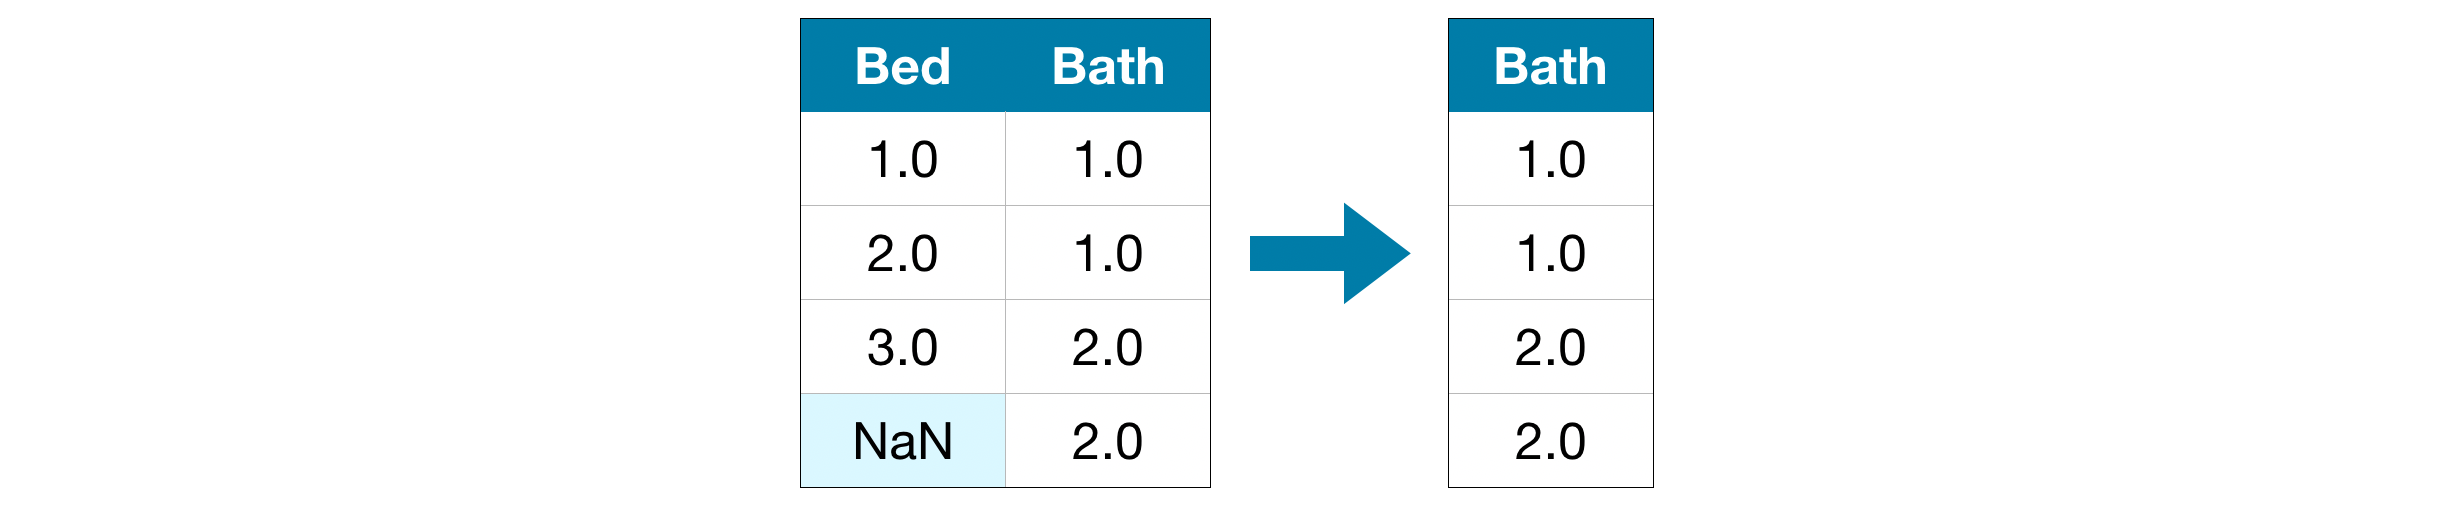

A menos que a maioria dos valores nas colunas descartadas esteja ausente, o modelo perde acesso a muitas informações (potencialmente úteis!) Com essa abordagem. Como um exemplo extremo, considere um conjunto de dados com 10.000 linhas, em que uma coluna importante está faltando uma única entrada. Essa abordagem eliminaria a coluna completamente!

### 2) Uma opção melhor: imputação
A imputação preenche os valores ausentes com algum número. Por exemplo, podemos preencher o valor médio ao longo de cada coluna.


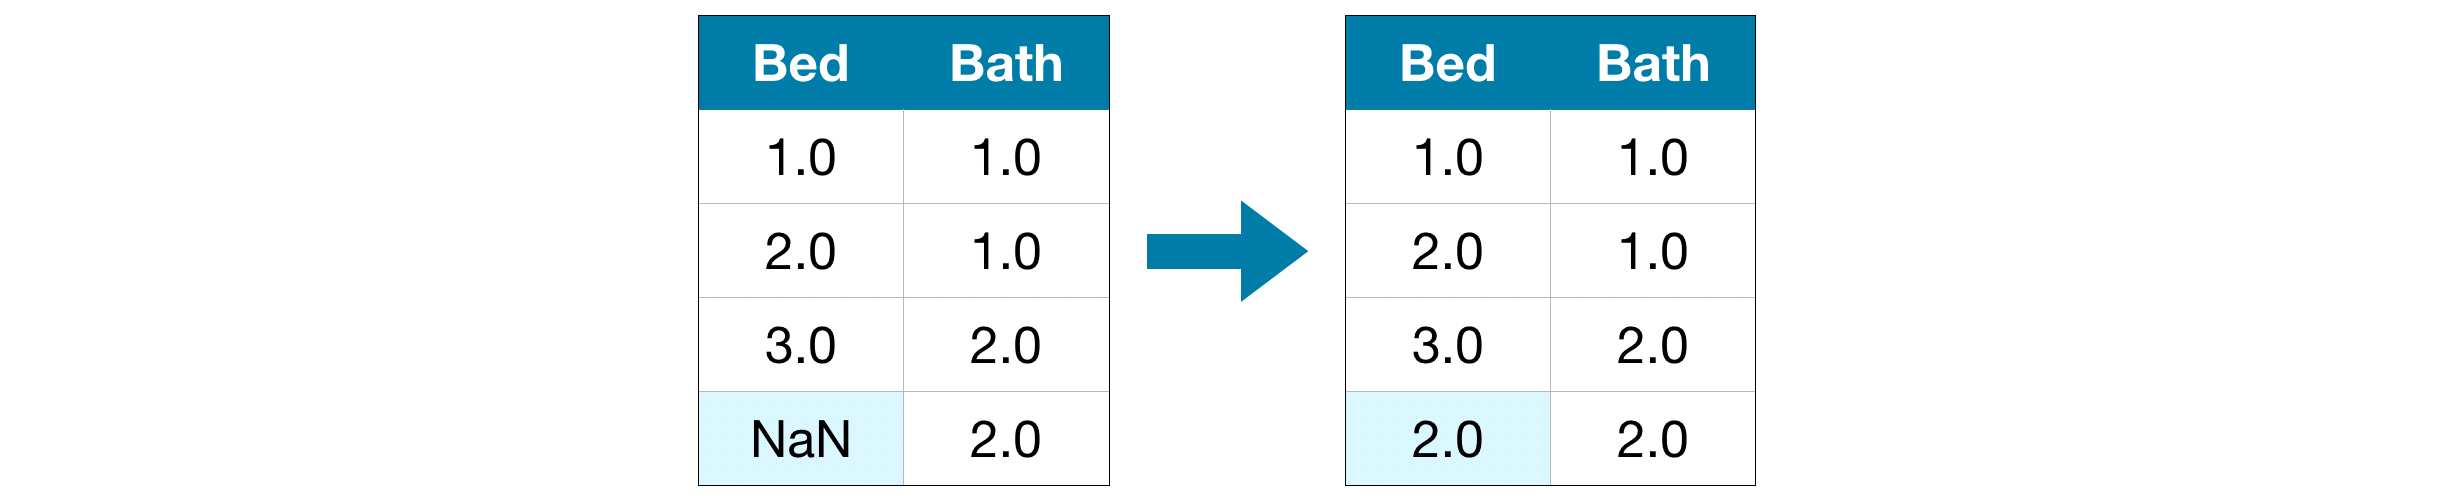

O valor imputado não será exatamente correto na maioria dos casos, mas geralmente leva a modelos mais precisos do que você obteria ao largar completamente a coluna.

### 3) Uma extensão à imputação
A imputação é a abordagem padrão e geralmente funciona bem. No entanto, os valores imputados podem estar sistematicamente acima ou abaixo dos valores reais (que não foram coletados no conjunto de dados). Ou linhas com valores ausentes podem ser exclusivas de alguma outra maneira. Nesse caso, seu modelo faria melhores previsões considerando quais valores estavam originalmente ausentes.

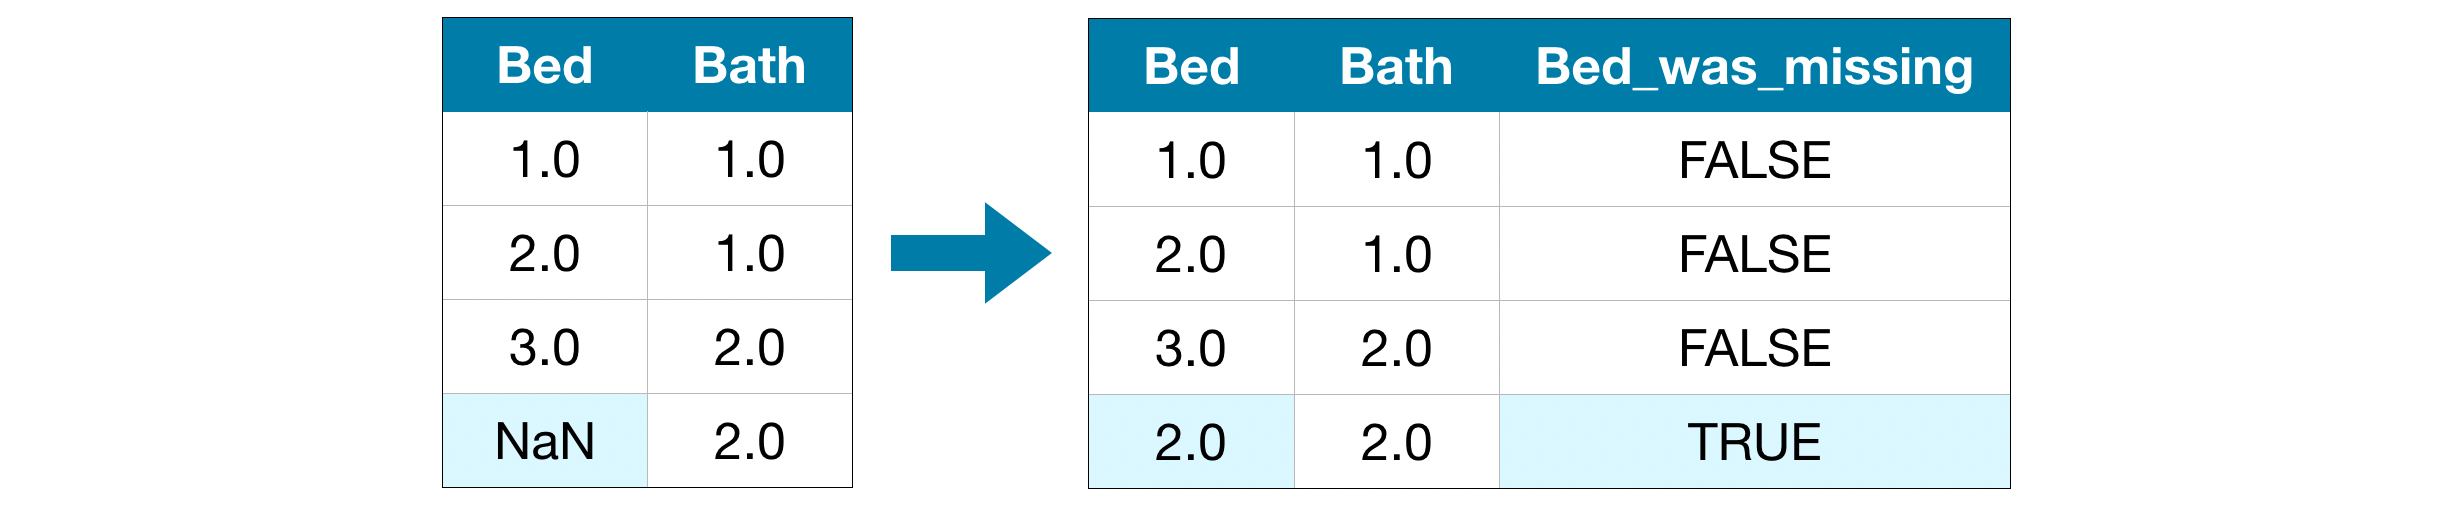

Nesta abordagem, imputamos os valores ausentes, como antes. Além disso, para cada coluna com entradas ausentes no conjunto de dados original, **adicionamos uma nova coluna que mostra a localização das entradas imputadas**. Em alguns casos, isso melhorará significativamente os resultados. Em outros casos, isso não ajuda em nada.

## Exemplo:
No exemplo, trabalharemos com o conjunto de dados Melbourne Housing. Nosso modelo usará informações como o número de quartos e o tamanho da terra para prever o preço da casa.

Não vamos nos concentrar na etapa de carregamento de dados. Em vez disso, você pode imaginar que já está com os dados de treinamento e validação em *X_train*, *X_valid*, *y_train* e *y_valid*.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data
data = pd.read_csv('melb_data.csv')

# Select target
y = data.Price

# To keep things simple, we'll use only numerical predictors
melb_predictors = data.drop(['Price'], axis=1)
X = melb_predictors.select_dtypes(exclude=['object'])

# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

### Definir função para medir a qualidade de cada abordagem
Definimos uma função *score_dataset()* para comparar diferentes abordagens para lidar com valores ausentes. Esta função relata o **erro absoluto médio (MAE)** de um modelo de floresta aleatório.

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

### 1. Pontuação da Abordagem 1 (Eliminar colunas com valores ausentes)
Como estamos trabalhando com conjuntos de **treinamento e validação**, tomamos o cuidado de **eliminar as mesmas colunas nos dois DataFrames**.

In [3]:
# Get names of columns with missing values
cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]

# Drop columns in training and validation data
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_valid = X_valid.drop(cols_with_missing, axis=1)

print("MAE da Abordagem 1 (Eliminar colunas com valores ausentes):")
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid))

MAE da Abordagem 1 (Eliminar colunas com valores ausentes):
183550.22137772635


### 2. Pontuação da Abordagem 2 (Imputação)
Em seguida, usamos o *SimpleImputer* para substituir os valores ausentes pelo **valor médio em cada coluna**.

Embora seja simples, o preenchimento do valor médio geralmente funciona muito bem (mas isso varia de acordo com o conjunto de dados). Embora os estatísticos tenham experimentado maneiras mais complexas de determinar valores imputados (como imputação de regressão, por exemplo), **as estratégias complexas geralmente não oferecem benefícios adicionais depois que você conecta os resultados a modelos sofisticados de aprendizado de máquina**.

In [4]:
from sklearn.impute import SimpleImputer

# Imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

print("MAE da Abordagem 2 (Imputação):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE da Abordagem 2 (Imputação):
178166.46269899711


Vemos que a Abordagem 2 tem MAE menor que a Abordagem 1, portanto, a Abordagem 2 teve um desempenho melhor nesse conjunto de dados.

### 3. Pontuação da abordagem 3 (uma extensão à imputação)
Em seguida, imputamos os valores ausentes, além de acompanharmos quais valores foram imputados.

In [5]:
# Make copy to avoid changing original data (when imputing)
X_train_plus = X_train.copy()
X_valid_plus = X_valid.copy()

# Make new columns indicating what will be imputed
for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()

# Imputation
my_imputer = SimpleImputer()
imputed_X_train_plus = pd.DataFrame(my_imputer.fit_transform(X_train_plus))
imputed_X_valid_plus = pd.DataFrame(my_imputer.transform(X_valid_plus))

# Imputation removed column names; put them back
imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_valid_plus.columns = X_valid_plus.columns

print("MAE from Approach 3 (An Extension to Imputation):")
print(score_dataset(imputed_X_train_plus, imputed_X_valid_plus, y_train, y_valid))

MAE from Approach 3 (An Extension to Imputation):
178927.503183954


Como podemos ver, a abordagem 3 teve um desempenho um pouco pior que a abordagem 2.

### Então, por que a imputação teve um desempenho melhor do que soltar as colunas?
Os dados de treinamento possuem 10864 linhas e 12 colunas, nas quais três colunas contêm dados ausentes. Para cada coluna, **menos da metade das entradas está ausente**. Assim, a eliminação das colunas remove muitas informações úteis e, portanto, faz sentido que a imputação tenha um desempenho melhor.

In [6]:
# Shape of training data (num_rows, num_columns)
print(X_train.shape)

# Number of missing values in each column of training data
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

(10864, 12)
Car               49
BuildingArea    5156
YearBuilt       4307
dtype: int64


### Conclusão
Como é comum, imputar valores ausentes (na Abordagem 2 e Abordagem 3) produziu melhores resultados, em relação a quando simplesmente descartamos colunas com valores ausentes (na Abordagem 1).